In [3]:
import pickle

# Path to your saved pickle file
pickle_file_path = "/home/metacloud/Documents/multi_modal_rag/pdf_pickle_output/pdf_data.pkl"

# Load the data
with open(pickle_file_path, "rb") as f:
    data = pickle.load(f)

# Access the variables
texts = data["texts"]
tables = data["tables"]
images = data["images"]

print(f"Loaded {len(texts)} text blocks, {len(tables)} tables, and {len(images)} images.")


Loaded 14 text blocks, 0 tables, and 640 images.


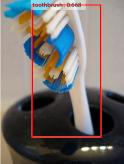

In [4]:

import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[-2])

In [19]:
td = texts[0].to_dict()

In [20]:
td

{'type': 'CompositeElement',
 'element_id': '5a79ad716599d3f1f6b79ea97e0eac33',
 'text': 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks\n\nShaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun\n\n6 1 0 2 n a J 6 ] V C . s c [ 3 v 7\n\nAbstract—State-of-the-art object detection networks depend on region proposal algorithms to hypothesize object locations. Advances like SPPnet [1] and Fast R-CNN [2] have reduced the running time of these detection networks, exposing region proposal computation as a bottleneck. In this work, we introduce a Region Proposal Network (RPN) that shares full-image convolutional features with the detection network, thus enabling nearly cost-free region proposals. An RPN is a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position. The RPN is trained end-to-end to generate high-quality region proposals, which are used by Fast R-CNN for detection. We further merge RPN and Fast R

In [15]:
td.keys()

dict_keys(['type', 'element_id', 'text', 'metadata'])

In [39]:
final_texts = []
final_tables = []
for text in texts:
    td = text.to_dict()
    clean_text = td['text']
    final_texts.append(clean_text)
    table = td.get("metadata", {}).get("text_as_html")
    # td["metadata"]["text_as_html"]
    if table:
        table = td["metadata"]["text_as_html"]
        final_tables.append(table)


In [ ]:
final_tables

In [28]:
from bs4 import BeautifulSoup
from IPython.display import display, HTML

# Parse with BeautifulSoup
soup = BeautifulSoup(final_tables[4], 'html.parser')

# Extract and display each table
tables = soup.find_all('table')
for i, table in enumerate(tables):
    print(f"Table {i+1}:")
    display(HTML(str(table)))

Table 1:


method,proposals},training data,mAP@5,"|mAP@L[.5, .95]|",mAP@.5,"|/mAP@[.5, .95]"
Fast R-CNN [2],"SS, 2000 |",COCO train,-,-,35.9,19.7
Fast R-CNN [impl. in this paper]|,"SS, 2000",| COCO train,38.6,18.9,39.3,19.3
Faster R-CNN,"RPN, 300}",COCO train,41.5,21.2,42.1,21.5
Faster R-CNN,"RPN,",300|}COCO trainval,-,-,42.7,21.9


Table 2:


VOC07,69.9,| 67.0
VOC07+12 VOC07++12,73.2 -,- 70.4


In [5]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_groq import ChatGroq  # or ChatOpenAI, as applicable

prompt = ChatPromptTemplate.from_template("""
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Table or text chunk: {element}
""")

llm = ChatGroq(temperature=0.3, model="llama3-8b-8192",api_key="qF1fDoSFWftMTJAFs526WGdyb3FY6kKPQjlCXIYUkhVsCXYUn")  # or ChatOpenAI(...)

format_runnable = RunnableLambda(lambda inputs: prompt.format_prompt(element=inputs["element"]))

summarize_chain = format_runnable | llm | StrOutputParser()

inputs = [{"element": text} for text in final_texts]
inputs = inputs[:3]

output = summarize_chain.batch(inputs, {"max_concurrency": 3})

for i, summary in enumerate(output):
    print(f"--- Summary {i+1} ---\n{summary}\n")


--- Summary 1 ---
Faster R-CNN is a real-time object detection system that uses Region Proposal Networks (RPNs) to generate high-quality region proposals, which are then used by Fast R-CNN for detection. The system achieves state-of-the-art object detection accuracy on PASCAL VOC 2007, 2012, and MS COCO datasets with a frame rate of 5fps on a GPU, and is the foundation of several 1st-place winning entries in ILSVRC and COCO 2015 competitions.

--- Summary 2 ---
The text discusses the evolution of object detection frameworks, including RPN and Faster R-CNN, which have been adopted and generalized to other methods such as 3D object detection, part-based detection, instance segmentation, and image captioning. The text also reviews related work on object proposal methods, deep networks for object detection, and shared computation of convolutions for efficient visual recognition.

--- Summary 3 ---
The Faster R-CNN object detection system consists of two modules: a deep fully convolutional 

In [51]:
final_texts[0]

'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks\n\nShaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun\n\n6 1 0 2 n a J 6 ] V C . s c [ 3 v 7\n\nAbstract—State-of-the-art object detection networks depend on region proposal algorithms to hypothesize object locations. Advances like SPPnet [1] and Fast R-CNN [2] have reduced the running time of these detection networks, exposing region proposal computation as a bottleneck. In this work, we introduce a Region Proposal Network (RPN) that shares full-image convolutional features with the detection network, thus enabling nearly cost-free region proposals. An RPN is a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position. The RPN is trained end-to-end to generate high-quality region proposals, which are used by Fast R-CNN for detection. We further merge RPN and Fast R-CNN into a single network by sharing their convolutional features—using the recently pop

In [ ]:
ll="qF1fDoSFWftMTJAFs526WGdyb3FY6kKPQjlCXIYUkhVsCXYUn"
vision_model =  ChatGroq(
        model_name="meta-llama/llama-4-scout-17b-16e-instruct",
        api_key=ll,
        temperature=0,
        
    )
def generate_images_summary(images, images_background_context: str = None):

    prompt_template = f"""Describe the image in detail.{images_background_context}"""
    messages = [
        (
            "user",
            [
                {"type": "text", "text": prompt_template},
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{image}"},
                },
            ],
        )
    ]

    prompt = ChatPromptTemplate.from_messages(messages)

    chain = prompt | vision_model | StrOutputParser()

    image_summaries = chain.batch(images)
    print(image_summaries)

    return image_summaries

In [62]:
t = """
Images are from 
Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks
Paper. they shows images of different scenes in real time and agrumented image.
"""
s = generate_images_summary(images[:5],t)

['The image depicts a scene of a man riding a horse, with the horse in motion. The man is dressed in a blue shirt and jeans, while the horse is brown with white markings on its face and hooves.\n\n**Key Elements:**\n\n*   **Man:** Wearing a blue shirt and jeans, riding a horse.\n*   **Horse:** Brown with white markings on its face and hooves, appears to be running or jumping.\n*   **Background:** \n    *   A truck is parked on the left side.\n    *   A person wearing red is standing on the right side.\n    *   Trees and a fence are visible in the background.\n    *   A blue tarp or blanket is on the ground behind the truck.\n\n**Image Features:**\n\n*   The image is labeled with "image" at the bottom and "feature map" at the top, indicating that it may be used to illustrate a concept related to image processing or computer vision.\n*   The image appears to be a real-world scene, possibly used for testing or demonstrating object detection algorithms, as suggested by the context of the p

In [63]:
s

['The image depicts a scene of a man riding a horse, with the horse in motion. The man is dressed in a blue shirt and jeans, while the horse is brown with white markings on its face and hooves.\n\n**Key Elements:**\n\n*   **Man:** Wearing a blue shirt and jeans, riding a horse.\n*   **Horse:** Brown with white markings on its face and hooves, appears to be running or jumping.\n*   **Background:** \n    *   A truck is parked on the left side.\n    *   A person wearing red is standing on the right side.\n    *   Trees and a fence are visible in the background.\n    *   A blue tarp or blanket is on the ground behind the truck.\n\n**Image Features:**\n\n*   The image is labeled with "image" at the bottom and "feature map" at the top, indicating that it may be used to illustrate a concept related to image processing or computer vision.\n*   The image appears to be a real-world scene, possibly used for testing or demonstrating object detection algorithms, as suggested by the context of the p

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABuAV8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCL4r/DCXTJZfEGgws9nIWe6to4+LbjO5QP4OvGPl+nTy3TLeO9uhHLNHChBO9xhenfANfaciLJGyOoZWBDKRkEeleBfEz4bLoLya1pMAOmOyiSFckwcdR/sZHrxn06ZzWmhElpoedyaaltNJHHfggnarAAhh74JxUkrXdpat

In [ ]:
import os
import base64
from langchain.chat_models import ChatGroq
from langchain.prompts.chat import ChatPromptTemplate
from langchain.output_parsers import StrOutputParser

# def encode_image_to_base64(image_path):
#     with open(image_path, "rb") as f:
#         return base64.b64encode(f.read()).decode("utf-8")

def generate_images_summary(image_paths, images_background_context: str = ""):
    # Compose the prompt template with placeholders for image + context
    prompt = ChatPromptTemplate.from_messages([
        (
            "user",
            [
                {"type": "text", "text": "Describe the image in detail."},
                {"type": "text", "text": images_background_context},
                {"type": "image_url", "image_url": {"url": "{image_url}"}},
            ],
        )
    ])

    # Initialize Groq LLM with vision-capable model
    groq_api_key = os.getenv("GROQ_API_KEY")
    llm = ChatGroq(
        model_name="llama-3.2-vision-preview",  # or "llama-3.2-90b-vision-preview" for higher quality
        api_key=groq_api_key,
        temperature=0,
    )

    # Create chain (prompt -> llm -> string output)
    chain = prompt | llm | StrOutputParser()

    summaries = []
    for path in image_paths:
        b64 = encode_image_to_base64(path)
        # Fill in the prompt input variables dynamically
        summary = chain.invoke({"image_url": f"data:image/jpeg;base64,{b64}"})
        summaries.append(summary)

    return summaries

if __name__ == "__main__":
    paths = ["example1.jpg", "example2.png"]
    context = "These images are from the latest marketing campaign."
    results = generate_images_summary(paths, context)
    for i, s in enumerate(results):
        print(f"Image {i+1} summary:\n{s}\n")
